In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os
plt.rcParams.update({'font.size': 18})

In [2]:
# Get all items (files and directories) in the current directory
# all_items = [item for item in os.listdir('.') if os.path.isdir(item) and item != '__pycache__']

all_items =['Nexullance_OPT',
            'Nexullance_MP_APST4',
            'Nexullance_MP_ASP',
            'Nexullance_IT',
            'ECMP_ASP',
            'ECMP_8SP']

In [3]:
# Create a dictionary where keys are directory names and values are their absolute paths
directories_dict = {
    item: os.path.abspath(item)
    for item in all_items
}

In [4]:
directories_dict

{'Nexullance_OPT': '/users/ziyzhang/topology-research/Nexullance_paper_data_gen/Nexullance_topos_compare/Nexullance_OPT',
 'Nexullance_MP_APST4': '/users/ziyzhang/topology-research/Nexullance_paper_data_gen/Nexullance_topos_compare/Nexullance_MP_APST4',
 'Nexullance_MP_ASP': '/users/ziyzhang/topology-research/Nexullance_paper_data_gen/Nexullance_topos_compare/Nexullance_MP_ASP',
 'Nexullance_IT': '/users/ziyzhang/topology-research/Nexullance_paper_data_gen/Nexullance_topos_compare/Nexullance_IT',
 'ECMP_ASP': '/users/ziyzhang/topology-research/Nexullance_paper_data_gen/Nexullance_topos_compare/ECMP_ASP',
 'ECMP_8SP': '/users/ziyzhang/topology-research/Nexullance_paper_data_gen/Nexullance_topos_compare/ECMP_8SP'}

In [17]:
def plot_bench_bars(_data: dict, methods_name: list, title: str, x_label: str, y_label: str, y_log: bool = False, normalized: bool = False, errors: dict = None):

    ## Example usage:
    # plot_data = {
    #     'Benchmark 1': [0.8, 0.7, 0.9],  
    #     'Benchmark 2': [0.6, 0.5, 0.7],  
    #     'Benchmark 3': [0.9, 0.8, 0.7],   
    #     'Benchmark 4': [0.9, 0.8, 0.7]
    # }

    # errors_data = {
    #     'Benchmark 1': [(0.05, 0.1), (0.06, 0.12), (0.03, 0.08)],  
    #     'Benchmark 2': [(0.03, 0.08), (0.04, 0.1), (0.02, 0.06)],  
    #     'Benchmark 3': [(0.04, 0.09), (0.05, 0.11), (0.03, 0.07)],   
    #     'Benchmark 4': [(0.03, 0.08), (0.04, 0.1), (0.02, 0.06)]
    # }

    # methods = ['Method 1', 'Method 2', 'Method 3']
    # plot_bench_bars(plot_data, errors_data, methods, "Performance Comparison", "Benchmark", "Performance", y_log=False, normalized=False)

    # Calculate bar width dynamically based on the number of methods
    num_methods = len(methods_name)
    bar_width = 0.7 / num_methods  # Adjust this scaling factor as needed

    # Generating x positions for each group of bars
    x_positions = np.arange(len(_data))  

    # Generate colors using a predefined colormap
    colors = cm.tab10(np.linspace(0, 1, num_methods))

    # Plotting
    plt.figure(figsize=(15, 3))  # Adjust size if necessary

    margin = 0.5
    plt.hlines(10.0, x_positions[0]-margin, x_positions[-1]+margin, colors="red")

    for i, method in enumerate(methods_name):
        # Extracting performance metrics for each method
        performance = [_data[bench][i] for bench in _data]
        if errors:
            error_min_max = np.array([errors[bench][i] for bench in errors])
        # Adjusting x positions for each group of bars
        x_positions_adjusted = x_positions + (i - num_methods//2) * bar_width
        # Plotting bars for each method
        plt.bar(x_positions_adjusted, performance, width=bar_width, align='center', label=method, color = colors[i])

        # Adding error bars
        if errors:
            error_bars = error_min_max.swapaxes(0, 1)
            plt.errorbar(x_positions_adjusted[:len(errors)], performance[:len(errors)], 
                        error_bars, fmt='none', ecolor='k', capsize=5)

    # Adding labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # if normalized:
    #     plt.ylim(0, 1)
    if y_log:
        plt.yscale("log")  
    plt.title(title)

    x_ticks = [key.replace("_", "-") for key in _data.keys()]
    x_ticks = [key.replace("-", "-\n") if key != "shift-1" else key for key in x_ticks]
    plt.xticks(x_positions, x_ticks)
    # Moving the legend outside the figure to the right
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)    
    plt.tight_layout()
    
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(x_positions[0]-margin, x_positions[-1]+margin)
    # plt.ylim(0, 11)

    # Show plot
    plt.show()


In [18]:
def plot_for_topo(topo_name, max_R=300):
    raw_data = {}
    for name, abs_path in directories_dict.items():
        raw_data[name] = pd.read_csv(os.path.join(os.path.join(abs_path, topo_name+".csv") ))

    
    plot_data = {
        'uniform': [],
        'shift_1': [],
        'router-cluster': [],
        'shift_half': [],
        'nearst-neighbour': [],
        'random-permute': []
    }
    plot_errors = {
        'uniform': [],
        'shift_1': [],
        'router-cluster': [],
        'shift_half': [],
        'nearst-neighbour': [],
        'random-permute': []
    }
    y_counter = {}.fromkeys(all_items, 0) # for each method, add up the y values, this is for calculating the average later
    for traffic in plot_data.keys():
        for _name, df in raw_data.items():
            _values = list(df[(df["traffic"]==traffic) & (df["V"]< max_R)]["Phi_per_EP"]) 
            ave_Phi_per_EP = np.average(_values)
            min_Phi_per_EP = np.min( _values ) 
            max_Phi_per_EP = np.max( _values ) 

            y_counter[_name] += ave_Phi_per_EP

            # _value = raw_data[topo_name][(raw_data[topo_name]["V"]==V) & (raw_data[topo_name]["traffic_pattern"]==traffic_pattern)]["Phi_NEXU[Gbps]"].values[0]
            plot_data[traffic].append(ave_Phi_per_EP)        
            plot_errors[traffic].append((ave_Phi_per_EP-min_Phi_per_EP, max_Phi_per_EP-ave_Phi_per_EP))
            
    plot_data['average'] = np.array(list(y_counter.values()))/len(plot_errors)
    # plot_bench_bars(plot_data, list(raw_data.keys()), 
    #                 f"{topo}F Networks, \n averaging each network topologies' network with R<{max_R}", 
    #                 "traffic demand patterns", "Phi per EP [GBps]", errors=plot_errors)
    plot_bench_bars(plot_data, list(raw_data.keys()), 
                    f"{topo_name} network topology, averaging all network configurations with R<{max_R}", 
                    "traffic demand patterns", "$\Phi$ per EP [GBps]", errors=plot_errors)

<>:43: SyntaxWarning: invalid escape sequence '\P'
<>:43: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_141581/3485450061.py:43: SyntaxWarning: invalid escape sequence '\P'
  "traffic demand patterns", "$\Phi$ per EP [GBps]", errors=plot_errors)


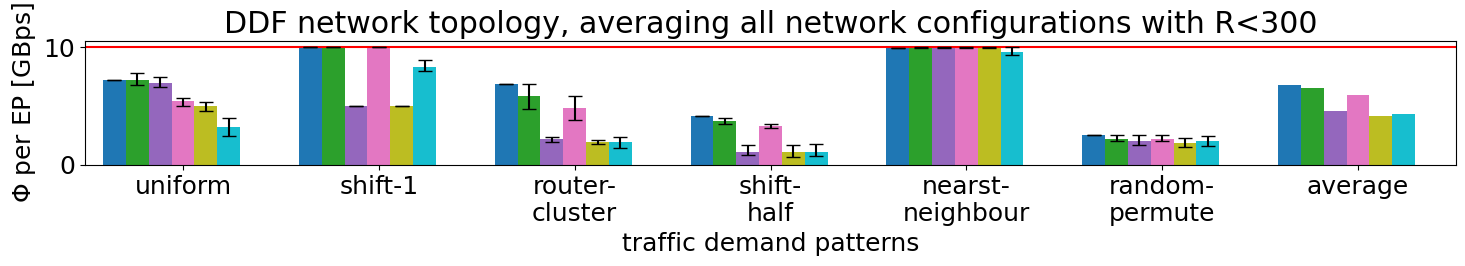

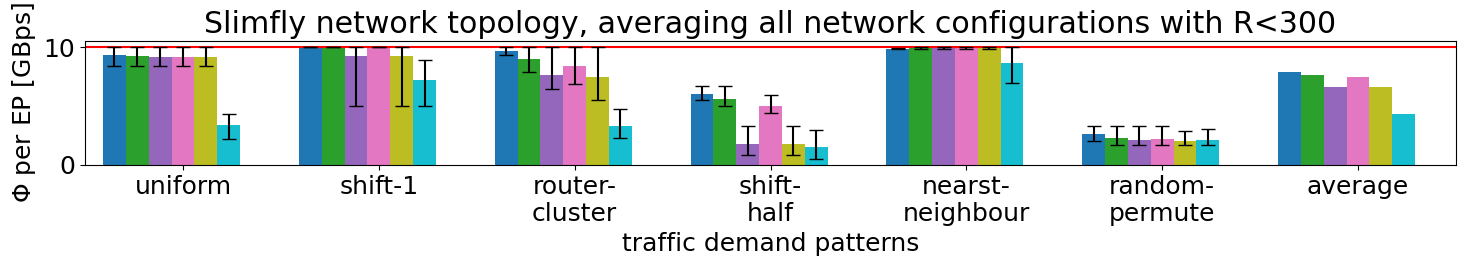

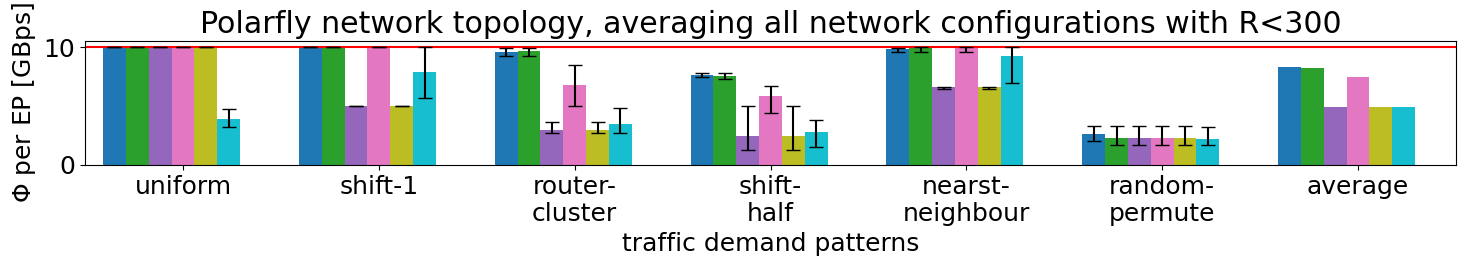

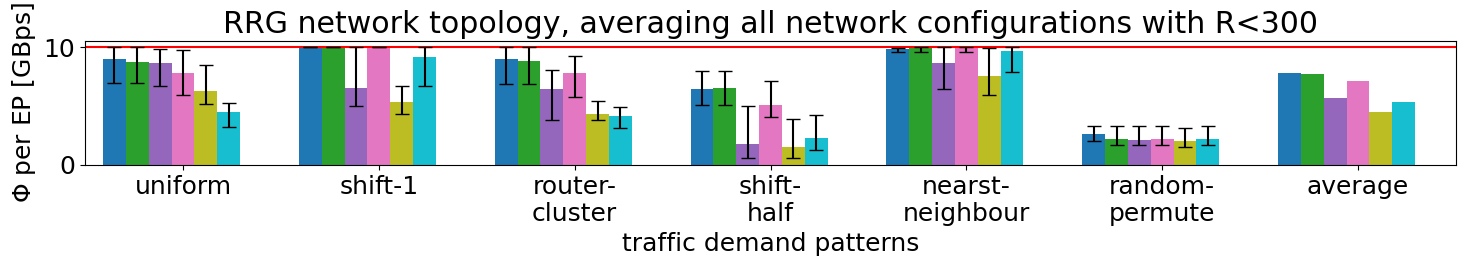

In [19]:
for topo in ["DDF", "Slimfly", "Polarfly", "RRG"]:
    plot_for_topo(topo)

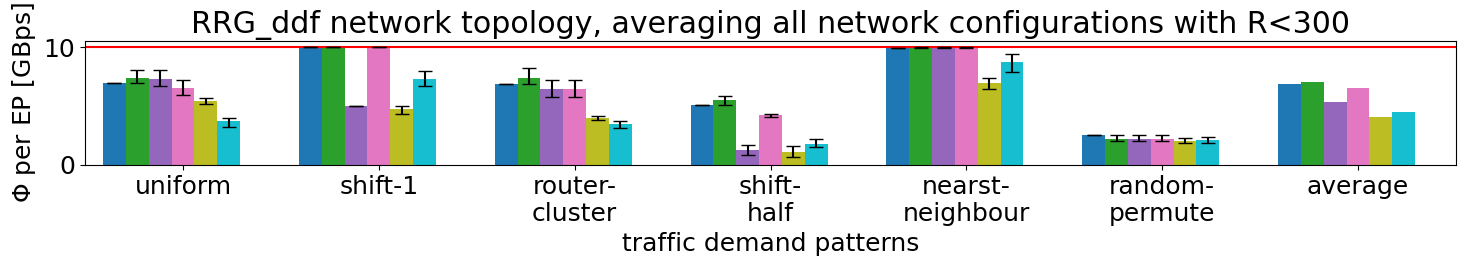

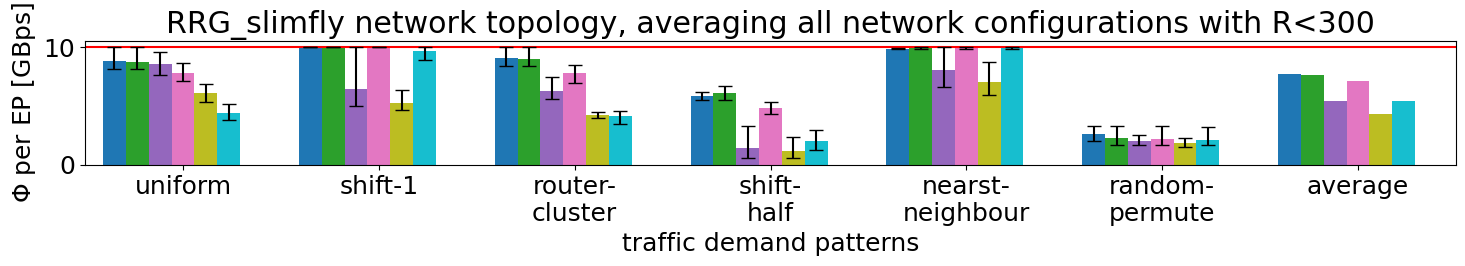

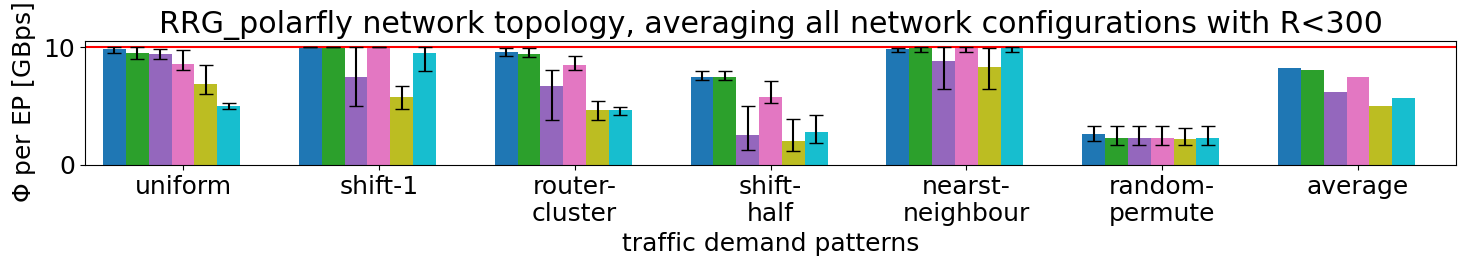

In [20]:
for topo in [ "RRG_ddf", "RRG_slimfly", "RRG_polarfly"]:
    plot_for_topo(topo)